# CausalML

[Causal ML](https://github.com/uber/causalml) is a python package that provides a suite of uplift modeling and causal inference methods using machine learning algorithms. It provides a standard interface that allows user to estimate the Conditional Average Treatment Effect (CATE) or Individual Treatment Effect (ITE) from experimental or observational data.

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from causalml.inference.meta import XGBTRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [7]:
# generate sysnthetic data
data = pd.DataFrame({
    'age': np.random.randint(18,65, size=1000),
    'income': np.random.normal(50_000, 15_000, size=1000),
    'treatment': np.random.binomial(1,0.5, size=1000),
    'outcome': np.random.normal(10_000, 1000, size=1000)
})

# add treatment impact on outcome
data['outcome'] = data['outcome']\
    + data['treatment'] * (1000-data['age']*100 + data['income']*0.1)
data

,age,income,treatment,outcome
0,37,73229.013538,0,11463.554248
1,53,43643.549317,0,10292.074681
2,44,8937.775303,1,6935.169261
3,25,41167.484480,0,9285.679179
4,57,40161.618905,0,10261.155867
...,...,...,...,...
995,20,37019.270496,1,11128.124147
996,55,38901.223778,0,11939.717616
997,52,60910.475890,0,9105.275000
998,41,67814.752683,1,13572.745024


In [5]:
scaler = StandardScaler()
features = ['age','income']
data[features] = scaler.fit_transform(data[features])

In [6]:
train, test = train_test_split(data, test_size=0.2, random_state=42)

## Conditional Average Treatment Effect (CATE)

In [10]:
cate_estimator = XGBTRegressor()

X_train = train[features]
treatment_train = train['treatment']
y_train = train['outcome']
cate_estimator.fit(
    X=X_train,
    treatment=treatment_train,
    y=y_train
)

X_test = test[features]
cate_estimates = cate_estimator.predict(X_test)

print('Estimated CATE:', np.mean(cate_estimates))

Estimated CATE: 1767.8707690429687


### Visualize CATE by Age and Income group

/tmp/ipykernel_3234/3389690912.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cate_by_age_bin = X_test_original.groupby('age_group')['cate'].mean()
/tmp/ipykernel_3234/3389690912.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cate_by_income_bin = X_test_original.groupby('income_group')['cate'].mean()


Text(0, 0.5, 'CATE')

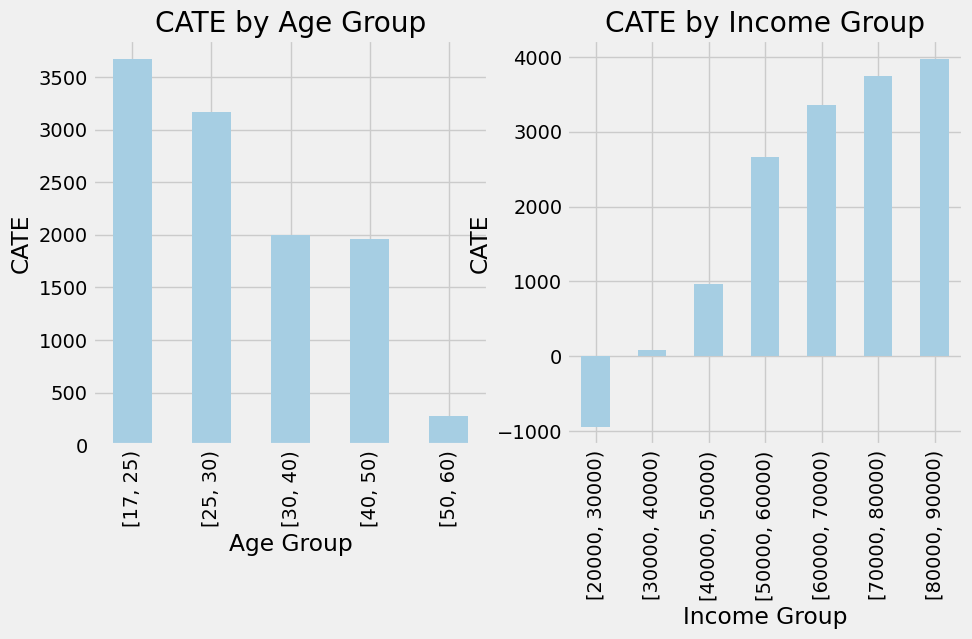

In [49]:
X_test_original = X_test.copy()
X_test_original[features] = scaler.inverse_transform(X_test[features])

age_bins_list = [17,25,30,40,50,60]
X_test_original.loc[:,'age_group'] = pd.cut(X_test_original['age'],
                                            bins=age_bins_list,
                                            right=False)

income_bins_list = [20_000,30_000,40_000,50_000,60_000,70_000,80_000,90_000]
X_test_original.loc[:,'income_group'] = pd.cut(X_test_original['income'],
                                               bins=income_bins_list,
                                               right=False)

X_test_original['cate'] = cate_estimates
cate_by_age_bin = X_test_original.groupby('age_group')['cate'].mean()
cate_by_income_bin = X_test_original.groupby('income_group')['cate'].mean()

fig, ax = plt.subplots(1,2,figsize=(10,5))
cate_by_age_bin.plot(kind='bar', ax=ax[0])
ax[0].set_title('CATE by Age Group')
ax[0].set_xlabel('Age Group')
ax[0].set_ylabel('CATE')
cate_by_income_bin.plot(kind='bar', ax=ax[1])
ax[1].set_title('CATE by Income Group')
ax[1].set_xlabel('Income Group')
ax[1].set_ylabel('CATE')